In [48]:
import scipy.io as sio
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '../../Libraries')
import JacksonsTSPackage as jts
from ltar import LTAR, diff, invert_diff

In [2]:
video = sio.loadmat('data/video.mat')
video

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 15:01:20 2013',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[array([[130, 121, 120, 120, 125, 124, 112, 113, 123, 122],
        [145, 143, 142, 141, 141, 140, 139, 141, 140, 135],
        [140, 140, 140, 141, 142, 143, 144, 148, 149, 148],
        [138, 138, 138, 138, 139, 141, 142, 144, 145, 145],
        [134, 137, 145, 140, 137, 135, 136, 137, 140, 138],
        [128, 128, 125, 121, 121, 120, 121, 118, 120, 120],
        [126, 126, 125, 126, 125, 125, 125, 124, 124, 122],
        [124, 124, 123, 124, 125, 124, 125, 125, 125, 123],
        [122, 122, 122, 122, 121, 121, 123, 122, 123, 122],
        [120, 120, 120, 119, 118, 119, 118, 119, 119, 118]], dtype=uint8),
         array([[130, 122, 120, 120, 122, 127, 115, 113, 128, 129],
        [145, 143, 142, 141, 141, 139, 138, 139, 140, 130],
        [140, 140, 140, 141, 143, 143, 144, 147, 149, 148],
        [139, 138, 138, 138, 139, 141, 142, 1

In [3]:
tensor_shape = (1171, 10, 10)
tensor_data = np.zeros(tensor_shape)
for i in range(tensor_shape[0]):
    tensor_data[i] = video['X'][0][i]
tensor_data

array([[[130., 121., 120., ..., 113., 123., 122.],
        [145., 143., 142., ..., 141., 140., 135.],
        [140., 140., 140., ..., 148., 149., 148.],
        ...,
        [124., 124., 123., ..., 125., 125., 123.],
        [122., 122., 122., ..., 122., 123., 122.],
        [120., 120., 120., ..., 119., 119., 118.]],

       [[130., 122., 120., ..., 113., 128., 129.],
        [145., 143., 142., ..., 139., 140., 130.],
        [140., 140., 140., ..., 147., 149., 148.],
        ...,
        [124., 124., 124., ..., 125., 125., 124.],
        [122., 122., 122., ..., 122., 122., 122.],
        [120., 121., 119., ..., 119., 119., 119.]],

       [[132., 126., 123., ..., 116., 127., 129.],
        [145., 142., 142., ..., 138., 139., 132.],
        [140., 140., 140., ..., 147., 149., 149.],
        ...,
        [124., 124., 124., ..., 125., 125., 124.],
        [122., 122., 122., ..., 122., 122., 122.],
        [120., 121., 119., ..., 119., 119., 119.]],

       ...,

       [[164., 160., 160

In [4]:
N = 1171
N_train = 1000
N_test = 171

In [5]:
def animate_tensor(tensor, N, save_path):
    global im
    global display_tensor
    display_tensor = tensor
    fig = plt.figure()
    im = plt.imshow(display_tensor[0], cmap=plt.get_cmap("gray"), animated = True)
    ani = FuncAnimation(fig, animate, interval = 100, frames = N, blit=True)
    plt.show()
    ani.save(save_path)
def animate(i):
    global im
    im.set_array(display_tensor[i])
    return im,
#animate_tensor(tensor_data, N, "all.gif")

In [6]:
train_tensor = jts.extract_train_tensor(tensor_data, N_train)
test_tensor = jts.extract_test_tensor(tensor_data, N_train, N_test)

In [7]:
#animate_tensor(test_tensor, N_test, "test.gif")

# LSTM

In [25]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        start_ix = i - n_steps
        # check if we are beyond the sequence
        if start_ix >= 0:
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[start_ix:i], sequence[i]
            X.append(seq_x)
            y.append(seq_y)
    return np.asarray(X), np.asarray(y)
n_steps = 10
sequence = tensor_data.reshape((N, 100))
X, y = split_sequence(sequence, n_steps)
X.shape

(1161, 10, 100)

In [26]:
lstm_N_train = 1000 - n_steps
lstm_N_test = N - N_train

In [27]:
train_X = X[:lstm_N_train]
train_X.shape

(990, 10, 100)

In [28]:
train_y = y[:lstm_N_train]
train_y.shape

(990, 100)

In [35]:
test_X = X[lstm_N_train:lstm_N_train+lstm_N_test]
test_X.shape

(171, 10, 100)

In [36]:
test_y = y[lstm_N_train:lstm_N_train+lstm_N_test]
test_y.shape

(171, 100)

In [37]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
n_features = 100
model.add(LSTM(100, activation='relu',return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.fit(train_X, train_y, epochs=200, verbose=1)

Epoch 1/200
31/31 [==============================] - 3s 6ms/step - loss: 13210.0438
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 7979.3134
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 882.3607
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 199.1182
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 143.1768
Epoch 6/200
31/31 [==============================] - 0s 6ms/step - loss: 130.4778
Epoch 7/200
31/31 [==============================] - 0s 6ms/step - loss: 123.6442
Epoch 8/200
31/31 [==============================] - 0s 6ms/step - loss: 117.9491
Epoch 9/200
31/31 [==============================] - 0s 6ms/step - loss: 112.4227
Epoch 10/200
31/31 [==============================] - 0s 6ms/step - loss: 107.5391
Epoch 11/200
31/31 [==============================] - 0s 6ms/step - loss: 106.2794
Epoch 12/200
31/31 [==============================] - 0s 7ms/step - loss: 101.7892
Epoch 13/2

In [38]:
yhat = model.predict(test_X, verbose=0)
predict_tensor = yhat.reshape((N_test, 10, 10))
predict_tensor.shape

(171, 10, 10)

In [39]:
lstm_error = jts.calc_mape_per_matrix(test_tensor, predict_tensor)
lstm_error = lstm_error.rename(columns={"MAPE": "LSTM"})
lstm_error

,LSTM
0,0.0475802
1,0.0485658
2,0.0484177
3,0.0511387
4,0.0511716
...,...
166,0.197708
167,0.177693
168,0.17701
169,0.167779


<AxesSubplot:>

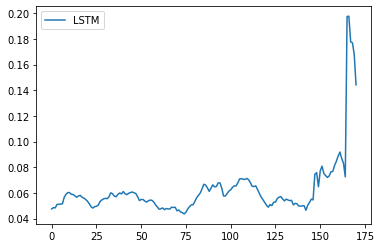

In [40]:
lstm_error.plot()

# LTAR

In [41]:
ltar = LTAR(train_tensor)
ltar.fit(n_steps, "dwt")

In [42]:
result_tensor = ltar.forecast(N_test)

In [43]:
#animate_tensor(test_tensor, N_test, "forecast.gif")

In [44]:
ltar_error = jts.calc_mape_per_matrix(test_tensor, result_tensor)
ltar_error = ltar_error.rename(columns={"MAPE": "LTAR with DCT"})
ltar_error

,LTAR with DCT
0,0.00835091
1,0.0132562
2,0.0163817
3,0.0224687
4,0.0241284
...,...
166,0.138364
167,0.141457
168,0.139261
169,0.138324


<AxesSubplot:>

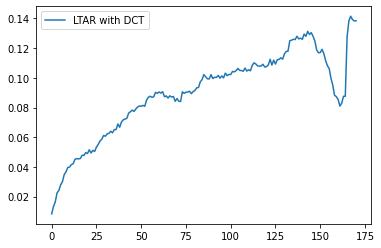

In [45]:
ltar_error.plot()

<AxesSubplot:>

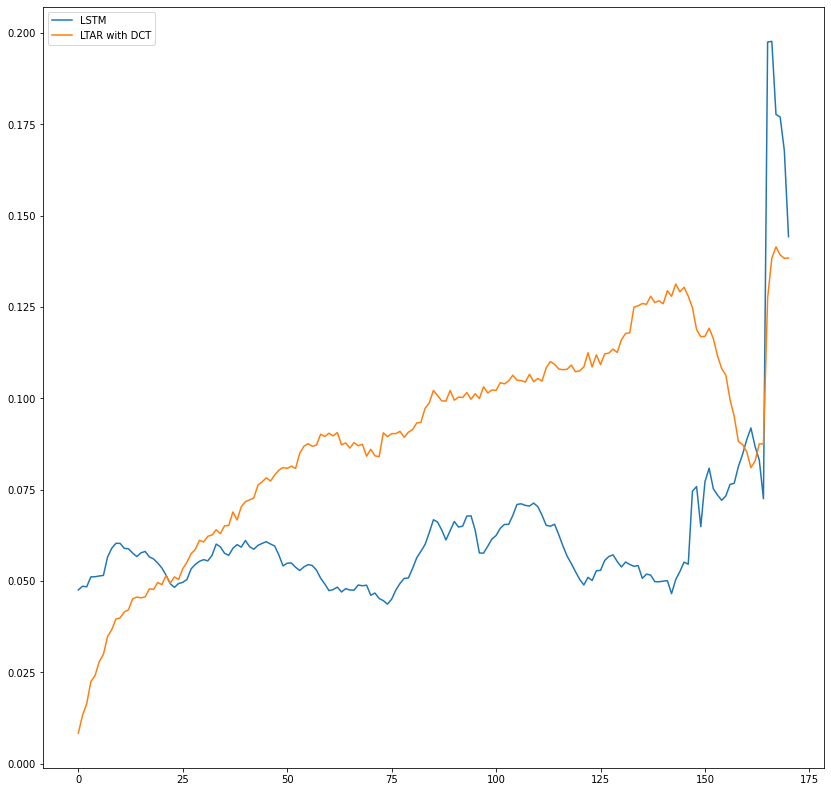

In [46]:
df = pd.concat([lstm_error, ltar_error], axis=1)
df.plot(figsize=(14, 14))

# L-TARI

In [49]:
ltar = LTAR(diff(train_tensor))
ltar.fit(n_steps, "dwt")

In [51]:
result_tensor = invert_diff(ltar.forecast(N_test), train_tensor)

In [52]:
ltari_error = jts.calc_mape_per_matrix(test_tensor, result_tensor)
ltari_error = ltari_error.rename(columns={"MAPE": "LTARI with DCT"})
ltari_error

,LTARI with DCT
0,0.00808568
1,0.0115486
2,0.0136565
3,0.0184827
4,0.0192211
...,...
166,0.202146
167,0.205332
168,0.203702
169,0.20367


<AxesSubplot:>

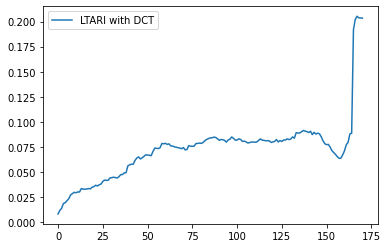

In [53]:
ltari_error.plot()

# L-STAR

<AxesSubplot:>

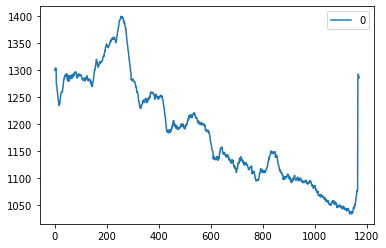

In [60]:
norms = []
for i in range(N):
    norms.append(np.linalg.norm(tensor_data[i], ord="fro"))
norms = pd.DataFrame(norms)
norms.plot()

In [84]:
interval = 10
ltar = LTAR(diff(train_tensor, interval))
ltar.fit(n_steps, "dwt")

In [85]:
result_tensor = invert_diff(ltar.forecast(N_test), train_tensor, interval)

In [86]:
lstar_error = jts.calc_mape_per_matrix(test_tensor, result_tensor)
lstar_error = lstar_error.rename(columns={"MAPE": "LSTAR with DCT"})
lstar_error

,LSTAR with DCT
0,0.0273442
1,0.0316555
2,0.0339533
3,0.0375374
4,0.0363133
...,...
166,0.203081
167,0.205139
168,0.201727
169,0.203239


<AxesSubplot:>

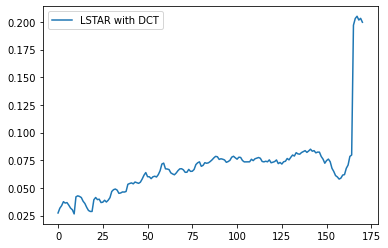

In [87]:
lstar_error.plot()

<AxesSubplot:>

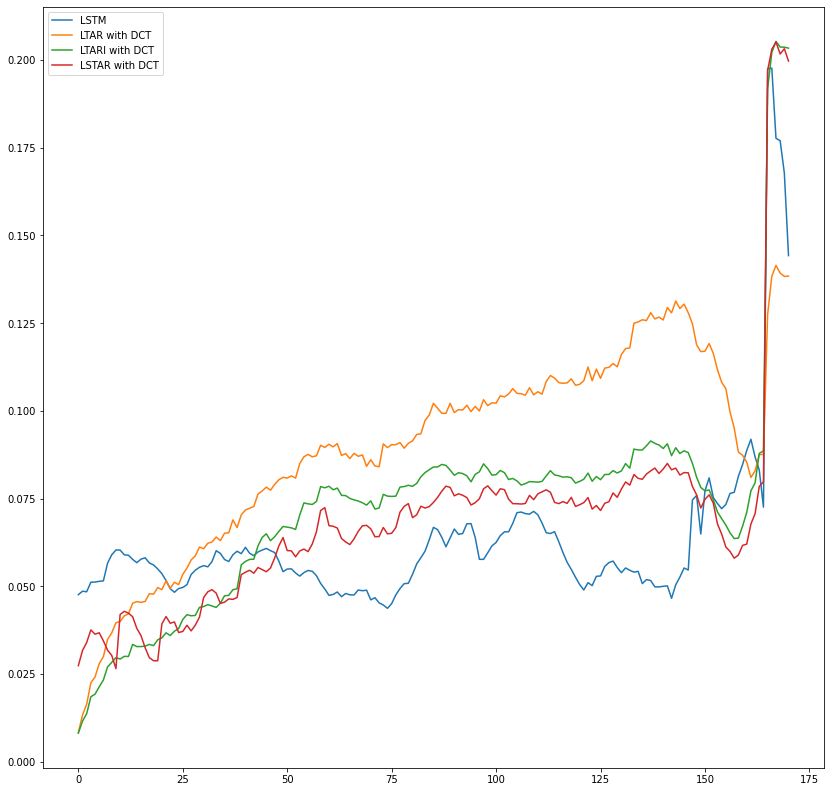

In [88]:
df = pd.concat([lstm_error, ltar_error, ltari_error, lstar_error], axis=1)
df.plot(figsize=(14, 14))